In [1]:
import numpy as np
import copy
import shap
import pandas as pd
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

from lib.models import CCM, CBM, MLP, LambdaNet
from lib.train import train_step_standard, train_step_xyz, train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c
from lib.utils import dfs_freeze

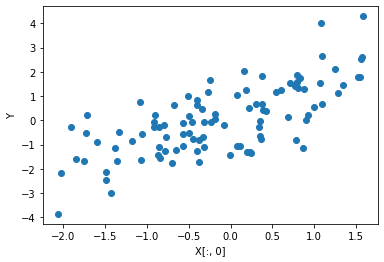

In [90]:
n = 1000
d = 3 # true number of concepts needed for classification
c = 1 # number of expert identified concepts
bs = 100
n_epochs = 200

def genCovX(C, n): # helper function to create N(0, C)
    # C is the covariance matrice (assume to be psd)
    # n is number of examples
    A = np.linalg.cholesky(C)
    d, _ = C.shape
    Z = np.random.randn(n, d)
    X = Z.dot(A.T) 
    return X.astype(np.float32)

def gen_correlated_data(n, d, corr=0.9):
    C = np.zeros((d, d))
    I = np.eye(d).astype(bool)
    C[~I] = corr
    C[I] = 1
    X = genCovX(C, n)
    return torch.from_numpy(X)

X = gen_correlated_data(n, d, corr=0.95)
Y = X[:, 0] + 1 * torch.randn(X.shape[0])
plt.scatter(X.numpy()[:100, 0], Y.numpy()[:100])
plt.xlabel("X[:, 0]")
plt.ylabel("Y")
plt.show()

epoch  19: loss 2.524e+00
epoch  39: loss 1.670e+00
epoch  59: loss 1.275e+00
epoch  79: loss 1.122e+00
epoch  99: loss 1.075e+00
epoch 119: loss 1.062e+00
epoch 139: loss 1.058e+00
epoch 159: loss 1.056e+00
epoch 179: loss 1.054e+00
epoch 199: loss 1.052e+00


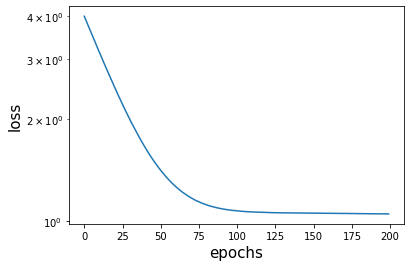

In [91]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True):
    # regular model
    net = MLP([d, 1])

    # train
    opt = optim.Adam(net.parameters())
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=lambda o, y: F.mse_loss(o.view(-1), y))
    if plot: plot_log(log)
    return net

loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
standard_net = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=n_epochs//10)

In [92]:
shap_x = pd.DataFrame(X.numpy()).sample(10)
shap_x

,0,1,2
886,-0.602990,-1.117209,-0.901351
152,1.624830,1.109961,1.854151
238,0.280909,-0.037622,0.356514
543,0.867050,0.602399,0.530460
352,-0.631151,-0.177824,-0.436042
585,0.310322,0.681578,0.354091
223,-0.162569,0.000519,0.370990
564,1.648281,1.196177,1.296007
446,-1.010451,-0.718419,-0.937353
793,0.132505,-0.162396,-0.203496


            0         1         2        O0
446 -1.010451 -0.718419 -0.937353 -0.914693
886 -0.602990 -1.117209 -0.901351 -0.867618
352 -0.631151 -0.177824 -0.436042 -0.436021
793  0.132505 -0.162396 -0.203496 -0.047221
223 -0.162569  0.000519  0.370990  0.044495
238  0.280909 -0.037622  0.356514  0.212795
585  0.310322  0.681578  0.354091  0.464288
543  0.867050  0.602399  0.530460  0.719482
564  1.648281  1.196177  1.296007  1.457451
152  1.624830  1.109961  1.854151  1.574852
Explaining O0


  0%|          | 0/10 [00:00<?, ?it/s]

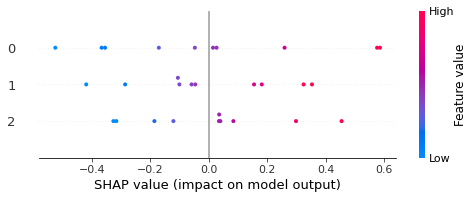

In [93]:
shap_net_x(standard_net, shap_x, bs, instance_idx=None, output_name="O", decimal=10)